## 3D cell tracking with Ultrack
This document shows how Ultrack can track cells in large fluorescence microscopy data. We use the zebrafish tail data from zebrahub acquired with DaXi.

Here, we use the image processing functions provided with Ultrack, but any other segmentation method could be used. For example, refer to the stardist_2 example to see how to use Ultrack with segmentation labels.

Note: This is not the same methodology used in the zebrahub paper. There, we used a convolutional neural network to predict the nuclei boundaries and the initial version of Ultrack software.

First, we import the required packages. You can install them using the conda environment file on this folder.

In [1]:
import napari
import numpy as np
import dask.array as da
from napari.utils.notebook_display import nbscreenshot
from rich.pretty import pprint

from ultrack.config import MainConfig, load_config
from ultrack import track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc.intensity import robust_invert
from ultrack.imgproc.segmentation import detect_foreground 
from ultrack.utils.array import array_apply, create_zarr

In [2]:
from aicsimageio import AICSImage
import glob2 as glob
import os
from skimage.transform import resize

image_folder = "D:\\Syd\\231016_EXP40_LCP1_UVB_300mJ\\PreUVB_Timelapse_Raw\\"
image_name_list = glob.glob(os.path.join(image_folder + "e2_LCP1_preZap_Timelapse_2023_10_16__20_29_18_539(*"))
ds_factor = 8
first_i = 0
last_i = 3
n_time_points = last_i - first_i
# image_list = []
for i, im in enumerate(image_name_list[first_i:last_i]):
    imObject = AICSImage(im)
    if i == 0:
        scale_vec = np.asarray(imObject.physical_pixel_sizes)
        sh = np.asarray(imObject.data.shape)
        sh_ds = np.round(sh[2:] / ds_factor).astype(int)
        image = np.empty((n_time_points, sh_ds[0], sh_ds[1], sh_ds[2]))

    from skimage.transform import resize
    data_raw = np.squeeze(imObject.data[0, 0, :, :, :])
    data_rs = resize(data_raw, sh_ds)
    image[i, :, :, :] = data_rs




KeyboardInterrupt



In [4]:
data_raw.shape

(276, 1920, 1920)

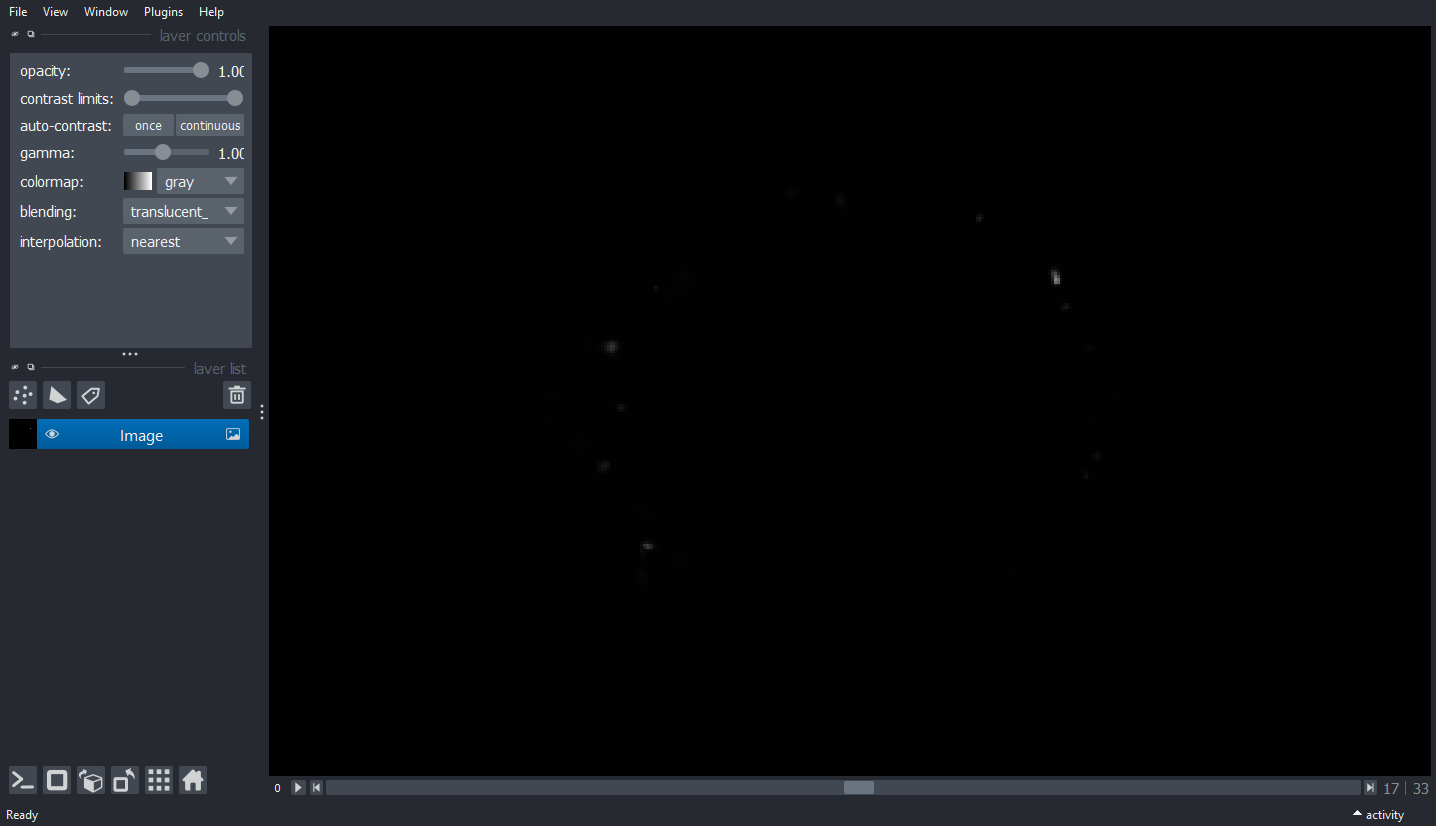

In [41]:
voxel_size = scale_vec

viewer = napari.view_image(image[0, :, : , :], scale=voxel_size)
# # viewer.add_image(image_data[2], gamma=0.7, contrast_limits=(0, 500))
# # viewer.window.resize(1800, 1000)
nbscreenshot(viewer)
# napari.run()

In [43]:
detection = np.empty(image.shape, dtype=np.uint8) #create_zarr(image.shape, bool, store_or_path="detection.zarr", overwrite=True)
voxel_size = scale_vec
array_apply(
    image,
    out_array=detection,
    func=detect_foreground,
    sigma=5.0,
    voxel_size=voxel_size,
)

Applying detect_foreground ...: 100%|██████████| 3/3 [00:17<00:00,  5.69s/it]


C:\Users\nlammers\AppData\Roaming\Python\Python310\site-packages\napari\layers\labels\labels.py:906: UserWarning: Contours are not displayed during 3D rendering
  warnings.warn(
C:\Users\nlammers\AppData\Roaming\Python\Python310\site-packages\napari\layers\labels\labels.py:906: UserWarning: Contours are not displayed during 3D rendering
  warnings.warn(


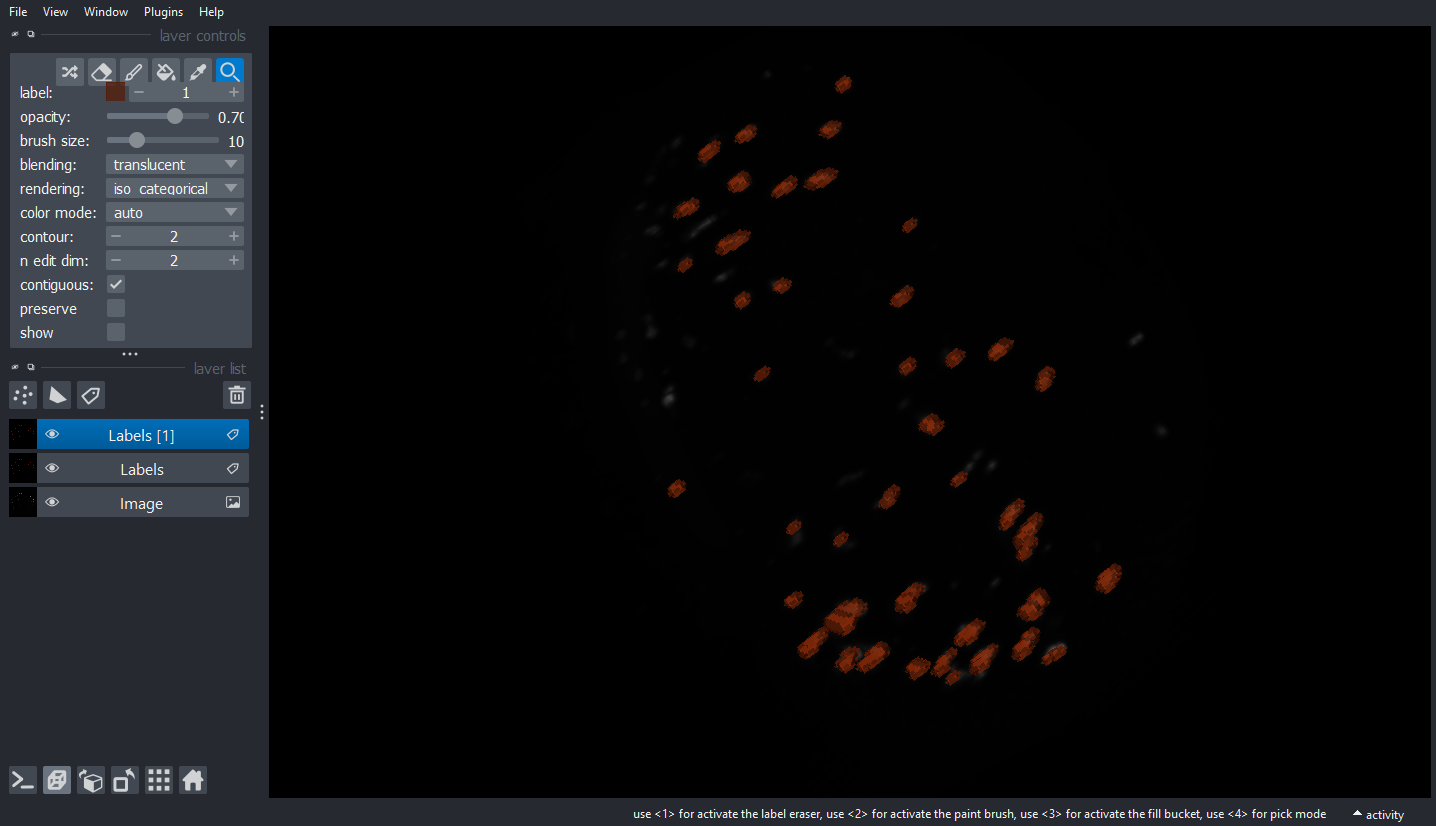

In [44]:
detection = detection.astype(int)

viewer.add_labels(
    detection[0, :, :, :],
    visible=True,
    # translate=(start_idx, 0, 0, 0),
    scale=voxel_size,
).contour = 2

nbscreenshot(viewer)

Ultrack requires an estimate of the cell boundaries, we approximate this by inverting the image using the robust_invert function and saving it to boundaries.zarr.

In [46]:
boundaries = np.empty(image.shape, dtype=np.uint8)
array_apply(
    image,
    out_array=boundaries,
    func=robust_invert,
    voxel_size=voxel_size,
)

viewer.add_image(boundaries[0, :, :, :], visible=False, scale=voxel_size)

Applying robust_invert ...: 100%|██████████| 3/3 [00:00<00:00, 18.87it/s]


<Image layer 'Image [1]' at 0x1cb56fc32b0>